# Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow

In [3]:
# Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer

In [4]:
#  get a list of yml files
dir_path = os.path.join("/content/drive/My Drive/", "UBS_Challenge")
df_dir_path = os.path.join("/content/drive/My Drive/", "UBS_Challenge", "df_save")

In [5]:
# Load the DataFrame from the pickle file
loaded_df = pd.read_pickle(os.path.join(df_dir_path, "dummyTrade1_Expiry_3y_Tenor_3y.pkl"))

# Display the loaded DataFrame
loaded_df

,index,Date,Expiry,Tenor,Swap Rate,atm-1.0%,atm-0.5%,atm,atm+0.5%,atm+1.0%,...,Vega shock -25,Vega shock -10,Vega shock -5,Vega shock 0,Vega shock 5,Vega shock 10,Vega shock 25,Vega shock 50,Vega shock 75,Vega shock 100
0,0,2021-01-13,3y,3y,0.926464,0.126845,0.097976,0.064286,0.101715,0.138284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-01-15,3y,3y,0.909138,0.126421,0.098006,0.063943,0.101482,0.138040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2021-01-18,3y,3y,0.911595,0.126314,0.097693,0.063760,0.101355,0.137900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-01-19,3y,3y,0.897848,0.125957,0.095190,0.063558,0.101041,0.137519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2021-01-20,3y,3y,0.906676,0.126691,0.092632,0.064357,0.101635,0.138296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,749,2024-01-08,3y,3y,3.110386,1.062981,1.065748,1.078728,1.101962,1.134488,...,13.054805,7.837098,11.382627,-10.217085,3.250830,-1.691202,-10.995377,2.988663,-1.774008,3.453038
750,750,2024-01-09,3y,3y,3.118041,1.053326,1.056185,1.069095,1.092077,1.124198,...,14.845626,12.220682,8.190720,3.654435,0.465170,-8.901062,1.681433,5.394763,0.341371,2.448011
751,751,2024-01-10,3y,3y,3.124089,1.078360,1.082165,1.095708,1.118975,1.151090,...,17.525630,0.038723,5.626285,-1.941919,1.514918,-6.057274,5.861185,5.004043,5.190675,4.022827
752,752,2024-01-11,3y,3y,3.080200,1.087504,1.092564,1.106701,1.129842,1.161218,...,8.916819,22.398760,21.049154,10.951858,4.202208,2.800921,-0.382249,-8.216384,7.142869,8.110645


# Data Pre-processing

In [6]:
n_clusters = 3 # Select n_clusters here

# Load the DataFrame from the pickle file
loaded_df = pd.read_pickle(os.path.join(df_dir_path, "dummyTrade1_Expiry_3y_Tenor_3y.pkl"))

loaded_df = loaded_df[['Date', 'Swap Rate', 'atm', 'Vega shock 0']]

# Rename the 'Vega shock 0' column
loaded_df.rename(columns={'atm': 'Implied Normal Volatility', 'Vega shock 0': 'Vega'}, inplace=True)

# Identify the first non-NaN index and count non-NaN values
first_non_nan_index = loaded_df['Vega'].first_valid_index()
non_nan_count = loaded_df['Vega'].count()

# Print the first non-NaN index and associated date
first_non_nan_date = loaded_df.loc[first_non_nan_index, 'Date']
print(f"First non-NaN index: {first_non_nan_index}, Date: {first_non_nan_date}")
print(f"Number of non-NaN values: {non_nan_count}")

# Identify the last NaN value's index
last_nan_index = loaded_df['Vega'][loaded_df['Vega'].isna()].index[-1]

# Print the last NaN index and associated date
last_nan_date = loaded_df.loc[last_nan_index, 'Date']
print(f"Last NaN index: {last_nan_index}, Date: {last_nan_date}")
print(f"First non-NaN index: {first_non_nan_index}")
print(f"Number of non-NaN values: {non_nan_count}")

print("\n\n=============\n\n")

# Function to compute moving averages and perform clustering
def compute_moving_average_and_clustering(df, column, window, shift_value, prefix):
    # Custom rolling mean function to handle partial windows
    df[f'{prefix}'] = df[column].rolling(window=window, min_periods=1).mean().shift(shift_value)

    # Extract non-NaN moving averages
    non_nan_moving_averages = df[f'{prefix}'].dropna().values.reshape(-1, 1)

    # Perform clustering with 4 clusters
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(non_nan_moving_averages)

    # Analyze the distribution of each cluster
    df[f'{prefix} Cluster'] = np.nan
    df.loc[df[f'{prefix}'].notna(), f'{prefix} Cluster'] = cluster_labels + 1

    # Calculate the medians of each cluster
    cluster_medians = df.loc[df[f'{prefix} Cluster'].notna(), [f'{prefix}', f'{prefix} Cluster']].groupby(f'{prefix} Cluster').median().abs()

    # Sort clusters by the absolute value of the median
    sorted_clusters = cluster_medians[f'{prefix}'].sort_values().index.tolist()

    # Remap cluster labels based on sorted order
    cluster_mapping = {old: new for new, old in enumerate(sorted_clusters, start=1)}
    df[f'{prefix} Cluster'] = df[f'{prefix} Cluster'].map(cluster_mapping)

    df[f'{prefix} Cluster'] = df[f'{prefix} Cluster'].astype('Int64')  # Convert to integer with NaN support

    for i in range(1, n_clusters + 1):
        cluster_data = df[df[f'{prefix} Cluster'] == i][f'{prefix}']
        print(f"Cluster {i} for {prefix}:")
        print(f"Min: {cluster_data.min()}")
        print(f"25th Percentile: {cluster_data.quantile(0.25)}")
        print(f"Median: {cluster_data.median()}")
        print(f"75th Percentile: {cluster_data.quantile(0.75)}")
        print(f"Max: {cluster_data.max()}")
        print("\n")

    # Categorize moving averages into clusters and create one-hot encoded columns
    def one_hot_encode_cluster(x, cluster_num):
        if pd.isna(x):
            return np.nan
        return 1 if x == cluster_num else 0

    # for i in range(1, n_clusters + 1):
    #     df[f'{prefix} Cluster {i}'] = df[f'{prefix} Cluster'].apply(lambda x: one_hot_encode_cluster(x, i)).astype('Int64')

    # # Ensure that cluster columns are NaN if the moving average is NaN
    # for i in range(1, n_clusters + 1):
    #     df[f'{prefix} Cluster {i}'] = df.apply(lambda row: np.nan if pd.isna(row[f'{prefix}']) else row[f'{prefix} Cluster {i}'], axis=1).astype('Int64')

# Define the windows
windows = {
    't+1 to t+5': (-1, -5)
}

# Apply the function to each window
for label, (start, end) in windows.items():
    compute_moving_average_and_clustering(loaded_df, 'Vega', start - end + 1, end, f'Vega MA {label}')

# Ensure that all columns are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the resulting DataFrame
loaded_df.tail(400)

First non-NaN index: 410, Date: 2022-09-02
Number of non-NaN values: 336
Last NaN index: 495, Date: 2023-01-02
First non-NaN index: 410
Number of non-NaN values: 336




Cluster 1 for Vega MA t+1 to t+5:
Min: -11.563781062
25th Percentile: 0.11304028800000004
Median: 2.803688842
75th Percentile: 7.974063095
Max: 16.101060218


Cluster 2 for Vega MA t+1 to t+5:
Min: 16.239456781999998
25th Percentile: 21.191405424000003
Median: 26.657466128
75th Percentile: 35.953899213999996
Max: 47.491319074


Cluster 3 for Vega MA t+1 to t+5:
Min: -11505.349523308
25th Percentile: -11502.908120558
Median: -11502.877896294
75th Percentile: -11502.149707084
Max: -11500.288522768




,Date,Swap Rate,Implied Normal Volatility,Vega,Vega MA t+1 to t+5,Vega MA t+1 to t+5 Cluster
354,2022-06-14,2.945934,0.072497,NaN,NaN,<NA>
355,2022-06-15,2.859921,0.072817,NaN,NaN,<NA>
356,2022-06-16,2.719031,0.070476,NaN,NaN,<NA>
357,2022-06-17,2.682615,0.069588,NaN,NaN,<NA>
358,2022-06-20,2.619587,0.067884,NaN,NaN,<NA>
359,2022-06-21,2.765887,0.068706,NaN,NaN,<NA>
360,2022-06-22,2.654932,0.067491,NaN,NaN,<NA>
361,2022-06-23,2.555744,0.067024,NaN,NaN,<NA>
362,2022-06-24,2.626183,0.068052,NaN,NaN,<NA>
363,2022-06-27,2.684751,0.067528,NaN,NaN,<NA>


# LSTM - Classification - n_steps = 60

In [7]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Hyperparameters
epochs=150
batch_size=32

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1,2))
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).reindex(columns=[0, 1, 2], fill_value=0).values

# Ensure that the dtype of X and y_categorical is float32
X = X.astype(np.float32)
y_categorical = y_categorical.astype(np.float32)

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint to save the best model
checkpoint_filepath = os.path.join(dir_path, 'best_lstm_classification_model_n_steps_60.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(dir_path, 'lstm_classification_final_weights_n_steps_60.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Epoch 1/150
5/5 [==============================] - 4s 245ms/step - loss: 1.0337 - accuracy: 0.6767 - val_loss: 1.1772 - val_accuracy: 0.0833
Epoch 2/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 1s 137ms/step - loss: 0.8550 - accuracy: 0.8421 - val_loss: 2.2143 - val_accuracy: 0.0833
Epoch 3/150
5/5 [==============================] - 1s 181ms/step - loss: 0.7760 - accuracy: 0.8421 - val_loss: 2.4278 - val_accuracy: 0.0833
Epoch 4/150
5/5 [==============================] - 1s 158ms/step - loss: 0.6677 - accuracy: 0.8421 - val_loss: 1.5605 - val_accuracy: 0.0833
Epoch 5/150
5/5 [==============================] - 1s 131ms/step - loss: 0.6490 - accuracy: 0.8421 - val_loss: 2.2678 - val_accuracy: 0.0833
Epoch 6/150
5/5 [==============================] - 1s 141ms/step - loss: 4.8523 - accuracy: 0.7895 - val_loss: 1.6353 - val_accuracy: 0.0833
Epoch 7/150
5/5 [==============================] - 1s 132ms/step - loss: 0.6317 - accuracy: 0.8421 - val_loss: 1.5930 - val_accuracy: 0.0833
Epoch 8/150
5/5 [==============================] - 1s 145ms/step - loss: 0.6184 - accuracy: 0.8421 - val_loss: 1.6451 - val_accuracy: 0.0833
Epoch 9/150
5/5 [========

2/2 [==============================] - 0s 19ms/step


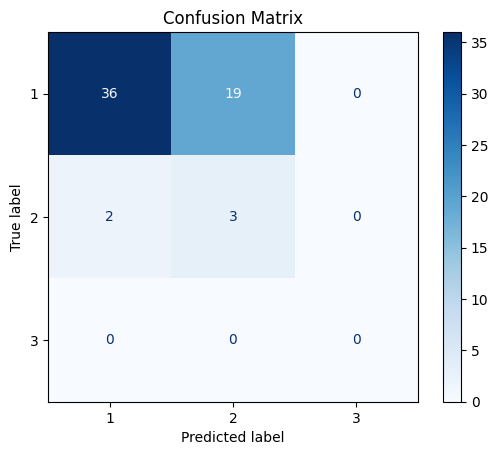

In [8]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1,2))
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).reindex(columns=[0, 1, 2], fill_value=0).values

# Ensure that the dtype of X and y_categorical is float32
X = X.astype(np.float32)
y_categorical = y_categorical.astype(np.float32)

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights
model.load_weights(os.path.join(dir_path, 'best_lstm_classification_model_n_steps_60.h5'))

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Adjust the classes back to 1, 2, 3
y_pred_classes_adjusted = y_pred_classes + 1
y_test_classes_adjusted = y_test_classes + 1

# Compute and display the confusion matrix
cm = confusion_matrix(y_test_classes_adjusted, y_pred_classes_adjusted, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# LSTM - Prediction - n_steps = 60

In [9]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Hyperparameters
epochs = 150
batch_size = 32

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1, 2))
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Define checkpoint to save the best model based on validation loss
checkpoint_filepath = os.path.join(dir_path, 'best_lstm_prediction_model_n_steps_60.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(dir_path, 'lstm_prediction_final_weights_n_steps_60.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_mse = history.history['mean_squared_error']
testing_mse = history.history['val_mean_squared_error']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training MSE:", training_mse)
print("Testing MSE:", testing_mse)

Epoch 1/150
5/5 [==============================] - 4s 295ms/step - loss: 806.3465 - mean_squared_error: 806.3465 - val_loss: 97.7158 - val_mean_squared_error: 97.7158
Epoch 2/150
1/5 [=====>........................] - ETA: 0s - loss: 701.5973 - mean_squared_error: 701.5973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 1s 127ms/step - loss: 797.7629 - mean_squared_error: 797.7629 - val_loss: 94.2035 - val_mean_squared_error: 94.2035
Epoch 3/150
5/5 [==============================] - 1s 124ms/step - loss: 784.7888 - mean_squared_error: 784.7888 - val_loss: 83.8047 - val_mean_squared_error: 83.8048
Epoch 4/150
5/5 [==============================] - 1s 121ms/step - loss: 720.7581 - mean_squared_error: 720.7581 - val_loss: 36404.3125 - val_mean_squared_error: 36404.3125
Epoch 5/150
5/5 [==============================] - 1s 119ms/step - loss: 1505.3076 - mean_squared_error: 1505.3076 - val_loss: 37.2121 - val_mean_squared_error: 37.2121
Epoch 6/150
5/5 [==============================] - 1s 112ms/step - loss: 718.8196 - mean_squared_error: 718.8196 - val_loss: 71.1099 - val_mean_squared_error: 71.1099
Epoch 7/150
5/5 [==============================] - 1s 144ms/step - loss: 723.1750 - mean_squared_error: 723.1750 - val_loss: 77.9557 - val_mean_squared_error: 77.9557
Ep

2/2 [==============================] - 1s 28ms/step
y_pred: [[ 3.4064765]
 [ 3.3891034]
 [ 3.3882024]
 [ 3.4034488]
 [ 3.4294255]
 [ 3.4655786]
 [ 3.510613 ]
 [ 3.5628111]
 [ 3.626519 ]
 [ 3.6954072]
 [ 3.7773507]
 [ 3.8700526]
 [ 3.9738421]
 [ 4.0842724]
 [ 4.201111 ]
 [ 4.322385 ]
 [ 4.448834 ]
 [ 4.568819 ]
 [ 4.685457 ]
 [ 4.803733 ]
 [ 4.920602 ]
 [ 5.0407305]
 [ 5.164205 ]
 [ 5.3070984]
 [ 5.458723 ]
 [ 5.622953 ]
 [ 5.7989125]
 [ 5.993991 ]
 [ 6.2074394]
 [ 6.4357266]
 [ 6.6784043]
 [ 6.9320393]
 [ 7.1930633]
 [ 7.468194 ]
 [ 7.760802 ]
 [ 8.060302 ]
 [ 8.378238 ]
 [ 8.698949 ]
 [ 9.037089 ]
 [ 9.380851 ]
 [ 9.732278 ]
 [10.094421 ]
 [10.476072 ]
 [10.855245 ]
 [11.200273 ]
 [11.550517 ]
 [11.866358 ]
 [12.147089 ]
 [12.372607 ]
 [12.583581 ]
 [12.751422 ]
 [12.840095 ]
 [12.827401 ]
 [12.753471 ]
 [12.620493 ]
 [12.392121 ]
 [12.148428 ]
 [11.952641 ]
 [11.712843 ]
 [11.3694515]]
Mean Squared Error: 37.2121
Mean Absolute Error: 5.3711


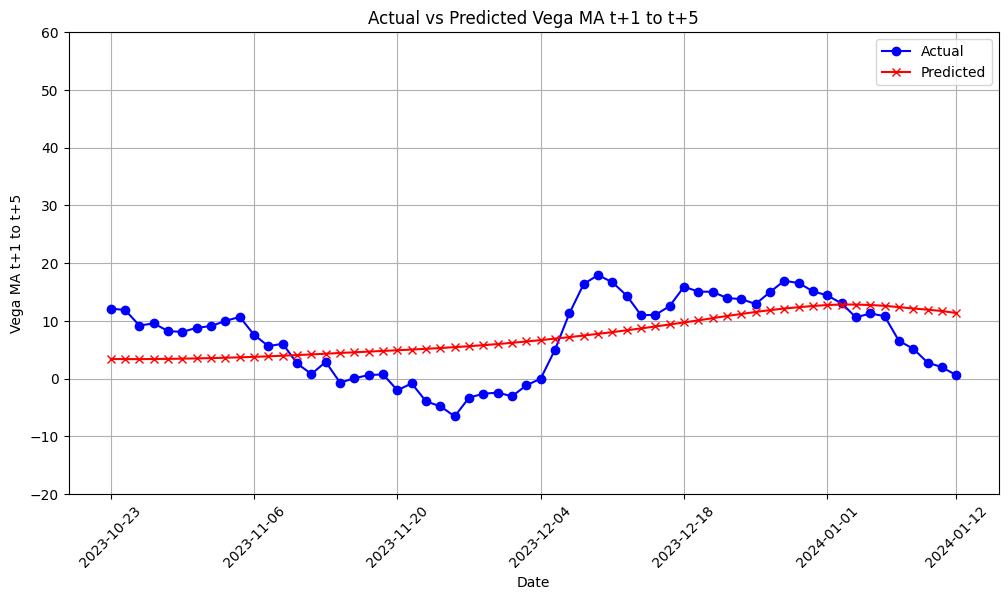

In [10]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1, 2))
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Load the model weights
model.load_weights(os.path.join(dir_path, 'best_lstm_prediction_model_n_steps_60.h5'))

# Make predictions
y_pred = model.predict(X_test)

# Print y_pred
print(f"y_pred: {y_pred}")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual', color='blue', marker='o')
plt.plot(df['Date'][-len(y_pred):], y_pred, label='Predicted', color='red', marker='x')

# Customize x-ticks to show date for every 10 entries and the last date
xticks = list(range(0, len(y_test), 10)) + [len(y_test) - 1]
xtick_labels = df['Date'].values[-len(y_test):][xticks]
plt.xticks(xticks, xtick_labels, rotation=45)

plt.xlabel('Date')
plt.ylabel('Vega MA t+1 to t+5')
plt.title('Actual vs Predicted Vega MA t+1 to t+5')
plt.legend()
plt.ylim(-20, 60)
# plt.axvline(x=xticks[-61], color='grey', linestyle='--')  # Vertical line at the last 60th date
plt.grid(True)
plt.show()

# LSTM - Classification - n_steps = 20

In [11]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Hyperparameters
epochs=150
batch_size=32

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1,2))
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).reindex(columns=[0, 1, 2], fill_value=0).values

# Ensure that the dtype of X and y_categorical is float32
X = X.astype(np.float32)
y_categorical = y_categorical.astype(np.float32)

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint to save the best model
checkpoint_filepath = os.path.join(dir_path, 'best_lstm_classification_model_n_steps_20.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(dir_path, 'lstm_classification_final_weights_n_steps_20.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Epoch 1/150
6/6 [==============================] - 3s 132ms/step - loss: 1.0970 - accuracy: 0.4045 - val_loss: 1.1063 - val_accuracy: 0.0833
Epoch 2/150
4/6 [===================>..........] - ETA: 0s - loss: 0.9953 - accuracy: 0.8359

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 31ms/step - loss: 0.9951 - accuracy: 0.7978 - val_loss: 1.1238 - val_accuracy: 0.0833
Epoch 3/150
6/6 [==============================] - 0s 28ms/step - loss: 0.8751 - accuracy: 0.8427 - val_loss: 1.4386 - val_accuracy: 0.0833
Epoch 4/150
6/6 [==============================] - 0s 30ms/step - loss: 0.6907 - accuracy: 0.8202 - val_loss: 4.1770 - val_accuracy: 0.0833
Epoch 5/150
6/6 [==============================] - 0s 44ms/step - loss: 0.5994 - accuracy: 0.8146 - val_loss: 0.8687 - val_accuracy: 0.5333
Epoch 6/150
6/6 [==============================] - 0s 34ms/step - loss: 0.6173 - accuracy: 0.7640 - val_loss: 1.2098 - val_accuracy: 0.0833
Epoch 7/150
6/6 [==============================] - 0s 34ms/step - loss: 0.5317 - accuracy: 0.8202 - val_loss: 1.5301 - val_accuracy: 0.0833
Epoch 8/150
6/6 [==============================] - 0s 31ms/step - loss: 0.5254 - accuracy: 0.8315 - val_loss: 1.8152 - val_accuracy: 0.0833
Epoch 9/150
6/6 [===============

2/2 [==============================] - 0s 11ms/step


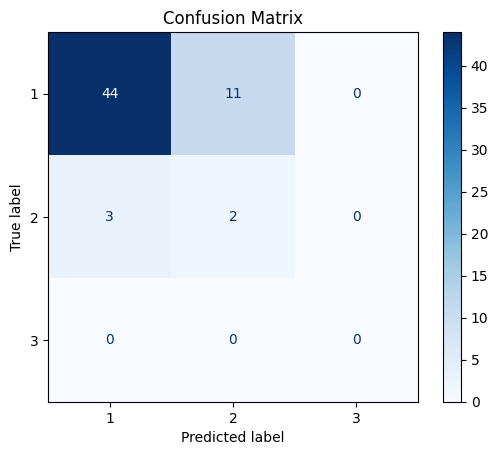

In [12]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1,2))
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).reindex(columns=[0, 1, 2], fill_value=0).values

# Ensure that the dtype of X and y_categorical is float32
X = X.astype(np.float32)
y_categorical = y_categorical.astype(np.float32)

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights
model.load_weights(os.path.join(dir_path, 'best_lstm_classification_model_n_steps_20.h5'))

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Adjust the classes back to 1, 2, 3
y_pred_classes_adjusted = y_pred_classes + 1
y_test_classes_adjusted = y_test_classes + 1

# Compute and display the confusion matrix
cm = confusion_matrix(y_test_classes_adjusted, y_pred_classes_adjusted, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# LSTM - Prediction - n_steps = 20

In [13]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Hyperparameters
epochs = 150
batch_size = 32

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1, 2))
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Define checkpoint to save the best model based on validation loss
checkpoint_filepath = os.path.join(dir_path, 'best_lstm_prediction_model_n_steps_20.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(dir_path, 'lstm_prediction_final_weights_n_steps_20.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_mse = history.history['mean_squared_error']
testing_mse = history.history['val_mean_squared_error']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training MSE:", training_mse)
print("Testing MSE:", testing_mse)

Epoch 1/150
6/6 [==============================] - 6s 230ms/step - loss: 3717263.7500 - mean_squared_error: 3717263.7500 - val_loss: 95.6352 - val_mean_squared_error: 95.6352
Epoch 2/150
3/6 [==============>...............] - ETA: 0s - loss: 2757172.2500 - mean_squared_error: 2757172.2500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 66ms/step - loss: 3717235.0000 - mean_squared_error: 3717235.0000 - val_loss: 92.6338 - val_mean_squared_error: 92.6338
Epoch 3/150
6/6 [==============================] - 0s 56ms/step - loss: 3717167.7500 - mean_squared_error: 3717167.7500 - val_loss: 82.7531 - val_mean_squared_error: 82.7531
Epoch 4/150
6/6 [==============================] - 0s 51ms/step - loss: 3717093.7500 - mean_squared_error: 3717093.7500 - val_loss: 202.4681 - val_mean_squared_error: 202.4681
Epoch 5/150
6/6 [==============================] - 0s 57ms/step - loss: 3716902.0000 - mean_squared_error: 3716902.0000 - val_loss: 839.7995 - val_mean_squared_error: 839.7995
Epoch 6/150
6/6 [==============================] - 0s 44ms/step - loss: 3716744.2500 - mean_squared_error: 3716744.2500 - val_loss: 187.6940 - val_mean_squared_error: 187.6940
Epoch 7/150
6/6 [==============================] - 0s 29ms/step - loss: 3716124.0000 - mean_squared_error: 3716124.0000 - val_loss: 521.

2/2 [==============================] - 0s 12ms/step
y_pred: [[ 0.30730617]
 [ 0.33651555]
 [ 0.33512312]
 [ 1.0722704 ]
 [ 6.276439  ]
 [ 8.009142  ]
 [ 8.0823145 ]
 [ 8.2125435 ]
 [ 8.29534   ]
 [ 8.424885  ]
 [ 8.577862  ]
 [ 8.626578  ]
 [ 8.567556  ]
 [ 8.579061  ]
 [ 8.620366  ]
 [ 8.627353  ]
 [ 8.677291  ]
 [ 8.94824   ]
 [ 9.364826  ]
 [ 9.73429   ]
 [ 9.932292  ]
 [10.113915  ]
 [10.15248   ]
 [10.119447  ]
 [ 9.972004  ]
 [ 9.887379  ]
 [ 9.87228   ]
 [ 9.829703  ]
 [ 9.632944  ]
 [ 9.501158  ]
 [ 9.323724  ]
 [ 9.060633  ]
 [ 8.750543  ]
 [ 8.525377  ]
 [ 8.394273  ]
 [ 8.308079  ]
 [ 8.182924  ]
 [ 8.151848  ]
 [ 8.177711  ]
 [ 8.094382  ]
 [ 8.030343  ]
 [ 7.982572  ]
 [ 8.03834   ]
 [ 7.972114  ]
 [ 7.9379773 ]
 [ 7.900149  ]
 [ 7.875585  ]
 [ 7.820042  ]
 [ 7.734884  ]
 [ 7.620829  ]
 [ 7.45278   ]
 [ 7.3655167 ]
 [ 7.3118215 ]
 [ 7.2444305 ]
 [ 7.1110787 ]
 [ 7.0365105 ]
 [ 6.9072137 ]
 [ 6.90767   ]
 [ 6.8984127 ]
 [ 6.840117  ]]
Mean Squared Error: 62.5490
Mean Absolu

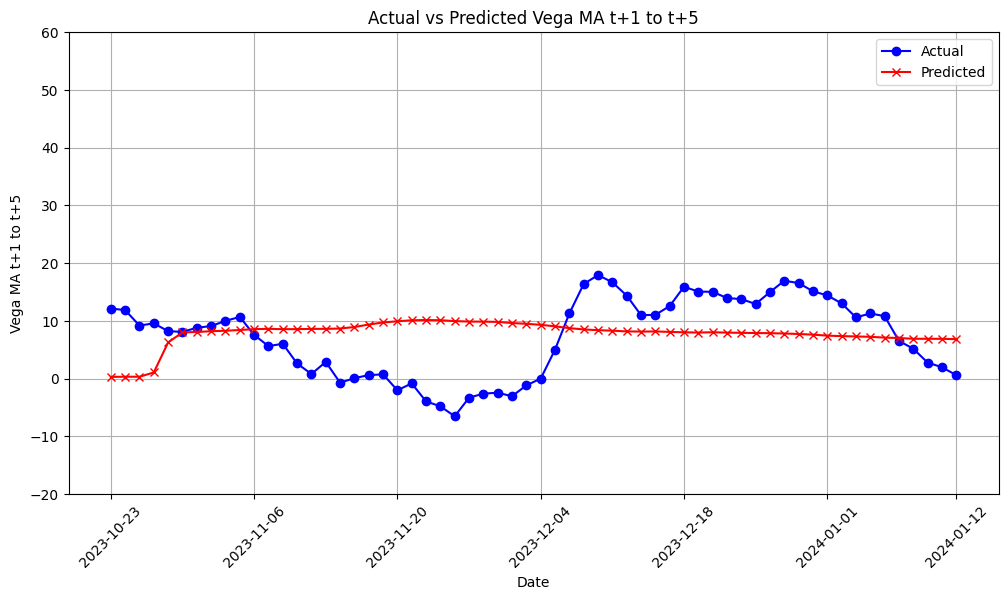

In [14]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 20

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(1, 2))
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Load the model weights
model.load_weights(os.path.join(dir_path, 'best_lstm_prediction_model_n_steps_20.h5'))

# Make predictions
y_pred = model.predict(X_test)

# Print y_pred
print(f"y_pred: {y_pred}")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual', color='blue', marker='o')
plt.plot(df['Date'][-len(y_pred):], y_pred, label='Predicted', color='red', marker='x')

# Customize x-ticks to show date for every 10 entries and the last date
xticks = list(range(0, len(y_test), 10)) + [len(y_test) - 1]
xtick_labels = df['Date'].values[-len(y_test):][xticks]
plt.xticks(xticks, xtick_labels, rotation=45)

plt.xlabel('Date')
plt.ylabel('Vega MA t+1 to t+5')
plt.title('Actual vs Predicted Vega MA t+1 to t+5')
plt.legend()
plt.ylim(-20, 60)
# plt.axvline(x=xticks[-61], color='grey', linestyle='--')  # Vertical line at the last 60th date
plt.grid(True)
plt.show()